# Time analysis

Prepare for benchmarking, write helper functions and save features

In [125]:
import os
if os.name=='nt':
    try:
        mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'
        os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
    except:
        pass

import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sys import getsizeof
import time
import gc
import tqdm

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
import pickle

def save_pickle(x, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(x, handle, protocol=pickle.HIGHEST_PROTOCOL)

def read_pickle(filename):
    with open(filename, 'rb') as handle:
        x = pickle.load(handle)
    return x

In [3]:
from numba import jit

@jit
def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf==0:
        return 0
    else:
        return sup / np.sqrt(inf)

@jit
def eval_mcc(y_true, y_prob, show=False):
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    new_mcc = 0
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
    if show:
        y_pred = (y_prob >= best_proba).astype(int)
        score = matthews_corrcoef(y_true, y_pred)
        print(score, best_mcc)
        plt.plot(mccs)
        return best_proba, best_mcc, y_pred
    else:
        return best_mcc
    
def mcc_eval(y_prob, dtrain):
    y_true = dtrain.get_label()
    best_mcc = eval_mcc(y_true, y_prob)
    return 'MCC', -best_mcc

In [4]:
def cross_val_predict_rskf(clf, x_train, y_train, n_splits=3, 
                           n_repeats=2, random_state=42, verbose=False):
    '''
    Repeated stratified KFold CV, returns predictions for 
    each repeat and average score.
    n_repeats: repetitions of CV
    '''
    scores = []
    n_trees = []
    clfs = []
    running_time = []
    
    rskf = RepeatedStratifiedKFold(n_repeats=n_repeats, n_splits=n_splits, 
                                   random_state=0)
    np.random.seed(random_state)
    for n, (train_index, test_index) in enumerate(rskf.split(x_train, y_train)):
        start_time = time.time()
        x_train_tmp, x_test_tmp = x_train.iloc[train_index], x_train.iloc[test_index]
        y_train_tmp, y_test_tmp = y_train.iloc[train_index], y_train.iloc[test_index]

        clf.random_state = np.random.randint(10000000)

        clf.fit(x_train_tmp, y_train_tmp, 
                eval_set=[(x_test_tmp, y_test_tmp)], 
                eval_metric=mcc_eval, early_stopping_rounds=10,
                verbose=verbose)
        scores.append(-clf.best_score)
        n_trees.append(clf.best_ntree_limit)
        clfs.append(clf)
        running_time.append(time.time()-start_time)
        print('Split {}, score = {:.3f}, best_ntree_limit = {}, total time = {:.3f} min'.format(n, scores[n], 
            clf.best_ntree_limit, sum(running_time)/60))

    print('Score mean = {:.3f}, std = {:.3f}'.format(np.mean(scores), np.std(scores)))
    
    return clfs, scores, n_trees, running_time

In [5]:
def cross_val_predict_skf_rm(clf, x_train, y_train, n_splits=3, 
                           n_repeats=2, random_state=42, verbose=False):
    '''
    Stratified KFold CV with repeated models
    '''
    scores = []
    n_trees = []
    clfs = []
    running_time = []

    skf = StratifiedKFold(n_splits=n_splits, random_state=0, shuffle=True)
    np.random.seed(random_state)

    for m in range(n_repeats):
        print('Repeat {}'.format(m))
        for n, (train_index, test_index) in enumerate(skf.split(x_train, y_train)):
            start_time = time.time()
            x_train_tmp, x_test_tmp = x_train.iloc[train_index], x_train.iloc[test_index]
            y_train_tmp, y_test_tmp = y_train.iloc[train_index], y_train.iloc[test_index]

            clf.random_state = np.random.randint(10000000)
            # print(clf.random_state)

            clf.fit(x_train_tmp, y_train_tmp, 
                    eval_set=[(x_test_tmp, y_test_tmp)], 
                    eval_metric=mcc_eval, early_stopping_rounds=10,
                    verbose=verbose)
            n_trees.append(clf.best_ntree_limit)
            scores.append(-clf.best_score)
            clfs.append(clf)
            running_time.append(time.time() - start_time)
            print('Split {}, score = {:.3f}, n_best_trees = {}, total time = {:.3f} min'.format(n, 
                scores[m*n_repeats+n], clf.best_ntree_limit, sum(running_time)/60))

    print('Score mean = {:.3f}, std = {:.3f}'.format(np.mean(scores), np.std(scores)))
    
    return clfs, scores, n_trees, running_time

### Load data and preprocessing
Load the train, test datasets, and responses. Put all the data into one dataframe and save for future use. 

In [6]:
# Number of rows to read
NROWS = None

In [7]:
# Set the dtypes for each column
x_train_date = pd.read_csv('data/train_date.csv.zip', nrows=2)
date_types = {k: np.float32 for k in x_train_date.columns}
date_types['Id'] = np.int64

In [8]:
# Load train and test data together
x_train_date = pd.read_csv('data/train_date.csv.zip', index_col=0, dtype=date_types, nrows=NROWS)
x_test_date = pd.read_csv('data/test_date.csv.zip', index_col=0, dtype=date_types, nrows=NROWS)

# Concatenate two datasets
x_date = pd.concat([x_train_date, x_test_date], keys=['train', 'test'])

# Delete original datasets since RAM is limited
del x_train_date, x_test_date
gc.collect()

480

In [16]:
# Load Response for train dataset
response_train = pd.read_csv('data/train_numeric.csv.zip', index_col=0, usecols=[0, 969], 
                       dtype={'Id':np.int64, 'Response': np.int8}, nrows=NROWS)

In [19]:
response_test = pd.read_csv('data/sample_submission.csv.zip', index_col=0, 
                       dtype={'Id':np.int64, 'Response': np.int8}, nrows=NROWS)
response_test.Response = -1
response = response_train.append(response_test)
del response_train, response_test
gc.collect()

92

In [20]:
x_date_join = x_date.join(response, on='Id')

del x_date
gc.collect()

In [22]:
# Extract station and feature names, and build a new pandas MultiIndex object
column_names = [tuple(int(b[1:]) for b in a.split('_')) for a in x_date_join.columns if a!='Response']
column_names.append((-1, -1, -1))
new_columns = pd.MultiIndex.from_tuples(column_names, names=['line', 'station', 'feature'])
x_date_join.columns = new_columns
x_date_join.index.names = ['dataset', 'Id']

In [ ]:
# This is too slow
# Save x_date_join, so next time I don't need to wait so long
# x_date_join.to_csv('data/x_date_join.csv.gz', compression='gzip')
# when read data, use 
# x_date = pd.read_csv('data/x_date_join.csv.gz', index_col=[0, 1], header=[0, 1, 2])

### Calculate start, end, and duration of parts on each station

In [86]:
x_date_join.head()

line                  0                                                      \
station              0                                                        
feature            1            3            5            7            9      
dataset Id                                                                    
train   4     82.239998    82.239998    82.239998    82.239998    82.239998   
        6           NaN          NaN          NaN          NaN          NaN   
        7   1618.699951  1618.699951  1618.699951  1618.699951  1618.699951   
        9   1149.199951  1149.199951  1149.199951  1149.199951  1149.199951   
        11   602.640015   602.640015   602.640015   602.640015   602.640015   

line                                                                         \
station                                                                       
feature            11           13           15           17           19     
dataset Id                                                                    
train   4     82.239998    82.239998    82.239998    82.239998    82.239998   
        6           NaN          NaN          NaN          NaN          NaN   
        7   1618.699951  1618.699951  1618.699951  1618.699951  1618.699951   
        9   1149.199951  1149.199951  1149.199951  1149.199951  1149.199951   
        11   602.640015   602.640015   602.640015   602.640015   602.640015   

line       ...     3                                            0  
station    ...    50                  51                       0   
feature    ...  4248 4250 4252 4254 4255 4257 4259 4261 4263 0     
dataset Id ...                                                     
train   4  ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    0  
        6  ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    0  
        7  ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    0  
        9  ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    0  
        11 ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    0  

[5 rows x 1157 columns]

In [156]:
start = {}
end = {}
duration = {}
for station in tqdm.tqdm_notebook(x_date_join.columns.get_level_values(1).unique()):
    if station!=-1:
        tmp = x_date_join.loc[slice(None), ([slice(None)], [station], [slice(None)])]
        start[station] = tmp.min(axis=1)
        end[station] = tmp.max(axis=1)
        duration[station] = end[station] - start[station]
start = pd.DataFrame.from_dict(start)
end = pd.DataFrame.from_dict(end)
duration = pd.DataFrame.from_dict(duration)

In [157]:
start['overall'] = start.min(axis=1)
start = start.join(response, on='Id')

end['overall'] = end.max(axis=1)
end = end.join(response, on='Id')

duration['overall'] = end['overall'] - start['overall']
duration = duration.join(response, on='Id')

### Analyze 

In [304]:
def calculate_mi(x, y, rm=True):
    df = pd.DataFrame({'variable': x, 'Response': y}).fillna(-99999)
    if rm:
        df = df[df.Response!=-1]
    df = df.groupby(['variable', 'Response']).Response.agg(['count']).reset_index(drop=False)
    df = df.pivot(index='variable', columns='Response', values='count').fillna(0)
    w = df.values
    
    # Calculate mutual information

    # Joint probabilities
    w = w/np.sum(w) 

    # Marginal probabilities
    p_x = np.sum(w, axis=1)
    p_x = p_x[..., None]
    p_y = np.sum(w, axis=0)
    p_y = p_y[None, ...]

    # Probabilities assuming independent x and y
    p_xy = p_x*p_y

    # MI
    mi = np.sum(np.nan_to_num(w * np.log2(w/p_xy)))
    
    return mi

In [305]:
u = start[['overall', 'Response']].copy()

u = u.reset_index(level=0, drop=True).reset_index(drop=False)

u['id_diff_1'] = u.Id.diff()

In [310]:
mi = calculate_mi(u.id_diff_1.values, u.Response.values, rm=True)

In [319]:
y = u.Response.values

In [320]:
n_tests = 100
rd = np.random.randint(low=-3*10**6, high=3*10**6, size=(len(u.Response.values), n_tests))

mi_tests = np.zeros((n_tests, ))
for i in tqdm.tqdm_notebook(range(n_tests)):
    mi_tests[i] = calculate_mi(rd[:, i], y, rm=True)

(array([ 2.,  2.,  3.,  6., 18., 16., 18., 20., 10.,  5.]),
 array([0.04920054, 0.04922832, 0.04925611, 0.0492839 , 0.04931169,
        0.04933947, 0.04936726, 0.04939505, 0.04942284, 0.04945062,
        0.04947841]),
 <a list of 10 Patch objects>)

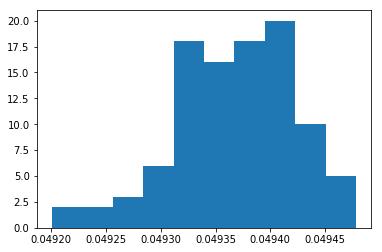

In [326]:
plt.hist(mi_tests)

In [322]:
mi

0.01793340300785115

In [ ]:
start_columns = start.columns[:-1]

for c in tqdm.tqdm_notebook(start_columns):
    mi_tests[i] = calculate_mi(start.loc[:, c].values, y, rm=False)

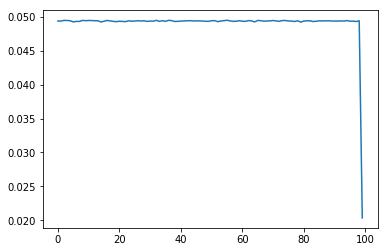

In [332]:
plt.plot(mi_tests)

### Create dataframe with start date and response

In [6]:
# start date, end date, duration, response
date = pd.concat([date_start, date_end, date_end-date_start], axis=1)

date.columns = ['date_start', 'date_end', 'date_duration']
# date.sort_values(by=['date_start', 'Id'], inplace=True)
date.dropna(axis=0, inplace=True)
date['Response'] = response

### Row distance to the previous and next error when rows are sorted by ID
$P(\text{error}\mid d=1)=0.054$, where $d$ is the distance to the previous or next error.

$P(\text{error}\mid d=1)$ is the same for $d$ measured from the previous or next error.

In [7]:
# Sort by ID, calculate row distance to last error
date.reset_index(inplace=True)
date['dist_1'] = np.zeros(len(date), dtype=np.int64)
date.loc[date.Response==1, 'dist_1'] = date.index[date.Response==1]
date['dist_1'] = date['dist_1'].shift(1).fillna(-1)
date.dist_1 = date.dist_1.cummax()
date.dist_1 = date.index - date.dist_1.astype(int)

date['dist_3'] = 9999999*np.ones(len(date), dtype=np.int64)
date.loc[date.Response==1, 'dist_3'] = date.index[date.Response==1]
date.dist_3 = date.dist_3.shift(-1).fillna(9999999).astype(int)
date.dist_3 = date.dist_3.iloc[::-1].cummin().iloc[::-1]
date.dist_3 = date.dist_3 - date.index

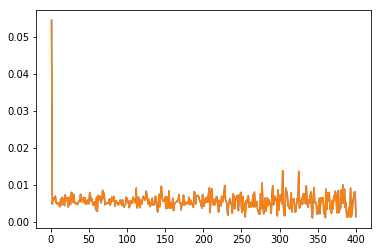

In [8]:
# Plot probability of error as distance, P(error|row distance to last error sorted by ID)
dist_1 = date.groupby('dist_1').Response.agg(['mean', 'sum', 'count'])
N = 400
plt.plot(dist_1.index.tolist()[:N], dist_1['mean'].values[:400])
dist_3 = date.groupby('dist_3').Response.agg(['mean', 'sum', 'count'])
plt.plot(dist_3.index.tolist()[:N], dist_3['mean'].values[:400])

The smallest 5 row distances and its statistics

In [9]:
dist_1.head()

,mean,sum,count
dist_1,,,
1,0.054514,375,6879
2,0.004767,31,6503
3,0.006489,42,6472
4,0.005910,38,6430
5,0.006101,39,6392


### ID difference to the previous and next row when sorted by `date_start` and `ID`
$P(\text{error}\mid d=1)=0.012$, where $d$ is the ID difference to the previous row

$P(\text{error}\mid d=1)=0.073$, where $d$ is the ID difference to the next row

In [10]:
# Distance in ID when sorted by date_start and ID, P(error|ID difference to previous one when sorted by start date and ID)
date.sort_values(['date_start', 'Id'], inplace=True)
date['dist_2'] = date.Id.diff().fillna(9999999).astype(int)
dist_2 = date.groupby('dist_2').Response.agg(['mean', 'sum', 'count'])
dist_2 = dist_2.loc[(dist_2['count']>100)]
dist_2

,mean,sum,count
dist_2,,,
1,0.012493,446,35700
2,0.006972,32,4590
3,0.016275,9,553
2174,0.000000,0,103


In [11]:
# Distance in ID when sorted by date_start and ID, P(error|ID difference to next one when sorted by start date and ID)
date.sort_values(['date_start', 'Id'], inplace=True)
date['dist_4'] = date.Id.diff(-1).fillna(9999999).astype(int)
dist_4 = date.groupby('dist_4').Response.agg(['mean', 'sum', 'count'])
dist_4 = dist_4.loc[(dist_4['count']>100)]
dist_4.sort_values('mean', ascending=False)

,mean,sum,count
dist_4,,,
-1,0.073866,2637,35700
-2,0.053159,244,4590
-3,0.039783,22,553
-2174,0.000000,0,103


### ID difference to the previous and next row when sorted by `date_end` and `ID`
$P(\text{error}\mid d=1)=0.015$, where $d$ is the ID difference to the previous row

$P(\text{error}\mid d=1)=0.053$, where $d$ is the ID difference to the next row

In [216]:
# Distance in ID when sorted by date_end and ID, P(error|ID difference to previous one when sorted by end date and ID)
date.sort_values(['date_end', 'Id'], inplace=True)
date['dist_7'] = date.Id.diff().fillna(9999999).astype(int)
dist_7 = date.groupby('dist_7').Response.agg(['mean', 'sum', 'count'])
#dist_7 = dist_7.loc[(dist_7['count']>100)]
dist_7.sort_values('count', ascending=False).head()

,mean,sum,count
dist_7,,,
1,0.015779,374,23703
2,0.007729,8,1035
2174,0.000000,0,144
2349,0.000000,0,142
2434,0.000000,0,139


In [217]:
# Distance in ID when sorted by date_end and ID, P(error|ID difference to previous one when sorted by end date and ID)
date.sort_values(['date_end', 'Id'], inplace=True)
date['dist_8'] = date.Id.diff(-1).fillna(9999999).astype(int)
dist_8 = date.groupby('dist_8').Response.agg(['mean', 'sum', 'count'])
#dist_7 = dist_7.loc[(dist_7['count']>100)]
dist_8.sort_values('count', ascending=False).head()

,mean,sum,count
dist_8,,,
-1,0.053875,1277,23703
-2,0.024155,25,1035
-2174,0.000000,0,144
-2349,0.000000,0,142
-2434,0.000000,0,139


### Check the distribution of features
It seems that these three features can identify most of the errors

Is it possitive to **make time granularity larger** and improve performance, as indicated by `1374.49` and `1374.48` below?

In [12]:
# The `date_start` with the most errors
date.groupby('date_start').Response.sum().sort_values(ascending=False).head()

date_start
1374.49    17
1374.48    15
1291.64    12
1373.25    11
1374.99    11
Name: Response, dtype: int64

In [208]:
date.loc[((date['date_start']==1374.99)) & (date['Response']==1)].head()
# date.loc[((date['date_start']==1374.49) | (date['date_start']==1374.48)) & (date['Response']==1)]

,Id,date_start,date_end,date_duration,Response,dist_1,dist_3,dist_2,dist_4,cnt,dist_5,dist_6,date_start_mod1,date_end_mod1,date_duration_bin1
963718,716735,1374.99,1376.7,1.71,1,80,70,15461,-1,1.0,10,2,309,326,1
963720,782676,1374.99,1376.7,1.71,1,480,1,65940,-1,1.0,2,1,309,326,1
963721,782677,1374.99,1376.7,1.71,1,1,341,1,-1,1.0,1,4,309,326,1
963725,851325,1374.99,1376.7,1.71,1,152,139,56885,-1,1.0,4,2,309,326,1
963727,854665,1374.99,1376.7,1.71,1,132,1,3339,-1,1.0,2,1,309,326,1


In [209]:
date.loc[((date['date_start']==1374.99))].head()

,Id,date_start,date_end,date_duration,Response,dist_1,dist_3,dist_2,dist_4,cnt,dist_5,dist_6,date_start_mod1,date_end_mod1,date_duration_bin1
963712,334882,1374.99,1499.19,124.20,0,87,86,-533690,-36054,1.0,4,6,309,207,103
963713,370936,1374.99,1376.71,1.72,0,38,154,36054,-30886,1.0,5,5,309,327,1
963714,401822,1374.99,1376.70,1.71,0,63,6,30886,-7525,1.0,6,4,309,326,1
963715,409347,1374.99,1376.70,1.71,0,11,558,7525,-18079,1.0,7,3,309,326,1
963716,427426,1374.99,1376.71,1.72,0,576,128,18079,-273848,1.0,8,2,309,327,1


### Check the distribution with all the features
`dist_1`, `dist_2`, and `dist_3` are active when equal 1

`dist_4` is active when larger than -3, according to the probabilities and priors. The specific threshold is the task of XGBoost.

The confidence interval of failure rate is estimated by Wald method, which is quite biased.

In [15]:
date['cnt'] = np.ones(len(date))
date['dist_ind_1'] = date['dist_1']==1
date['dist_ind_3'] = date['dist_3']==1
date['dist_ind_2'] = date['dist_2']==1
date['dist_ind_4'] = date['dist_4']>=-2
dist = date.groupby(['dist_ind_1', 'dist_ind_3', 'dist_ind_2', 'dist_ind_4']).sum()[['Response', 'cnt']]
dist['failure_rate'] = dist['Response']/dist['cnt']
# dist = dist[dist.cnt>50]
dist['confidence_interval'] = 1.96 * np.sqrt(dist.failure_rate * (1-dist.failure_rate) / dist.cnt) 
dist['confidence_inverval_ratio'] = dist['confidence_interval'] / dist.failure_rate
dist.sort_values('confidence_inverval_ratio', ascending=True)

Response        cnt  \
dist_ind_1 dist_ind_3 dist_ind_2 dist_ind_4                        
False      False      False      False           3509  1040984.0   
                                 True            2531    95582.0   
           True       False      True             340      766.0   
True       False      True       True             177      410.0   
                                 False            153     2205.0   
           True       True       True               9       10.0   
False      False      True       False             55    26510.0   
                                 True              46     6378.0   
True       False      False      False             19     3853.0   
False      True       False      False             17     5891.0   
True       False      False      True              12      366.0   
           True       False      True               3        4.0   
False      True       True       True               3       26.0   
True       True       True       False              2       12.0   
False      True       True       False              1      149.0   
True       True       False      False              0       19.0   

                                             failure_rate  \
dist_ind_1 dist_ind_3 dist_ind_2 dist_ind_4                 
False      False      False      False           0.003371   
                                 True            0.026480   
           True       False      True            0.443864   
True       False      True       True            0.431707   
                                 False           0.069388   
           True       True       True            0.900000   
False      False      True       False           0.002075   
                                 True            0.007212   
True       False      False      False           0.004931   
False      True       False      False           0.002886   
True       False      False      True            0.032787   
           True       False      True            0.750000   
False      True       True       True            0.115385   
True       True       True       False           0.166667   
False      True       True       False           0.006711   
True       True       False      False           0.000000   

                                             confidence_interval  \
dist_ind_1 dist_ind_3 dist_ind_2 dist_ind_4                        
False      False      False      False                  0.000111   
                                 True                   0.001018   
           True       False      True                   0.035185   
True       False      True       True                   0.047945   
                                 False                  0.010607   
           True       True       True                   0.185942   
False      False      True       False                  0.000548   
                                 True                   0.002077   
True       False      False      False                  0.002212   
False      True       False      False                  0.001370   
True       False      False      True                   0.018244   
           True       False      True                   0.424352   
False      True       True       True                   0.122806   
True       True       True       False                  0.210862   
False      True       True       False                  0.013110   
True       True       False      False                  0.000000   

                                             confidence_inverval_ratio  
dist_ind_1 dist_ind_3 dist_ind_2 dist_ind_4                             
False      False      False      False                        0.033032  
                                 True                         0.038440  
           True       False      True                         0.079270  
True       False      True       True                         0.111059  
                                 False                    

## Additional features

In [16]:
# Drop redundant rows and reset index
date.drop(['dist_ind_1', 'dist_ind_3', 'dist_ind_2', 'dist_ind_4'], axis=1, inplace=True)

date.reset_index(drop=True, inplace=True)

### Row distance to previous error when sorted by start date and ID
$P(\text{error}\mid d=1)=0.065$, $d$ is the row distance.

Notice that the number of samples per value of `dist_5` is quite uniformly distributed. `dist_5=1` has 6878 samples and `dist_5=300` has 1144 samples.

In [17]:
date['dist_5'] = np.zeros(len(date), dtype=int)
date.loc[date.Response==1, 'dist_5'] = date.index[date.Response==1]
date['dist_5'] = date['dist_5'].shift(1).fillna(-9999999).astype(int)
date['dist_5'] = date['dist_5'].cummax()
date['dist_5'] = date.index - date.dist_5
date.iloc[282:290]
# date.head()

,Id,date_start,date_end,date_duration,Response,dist_1,dist_3,dist_2,dist_4,cnt,dist_5
282,479337,0.4,0.46,0.06,0,50,485,20249,-43466,1.0,282
283,522803,0.4,1.61,1.21,0,207,393,43466,-25844,1.0,283
284,548647,0.4,0.46,0.06,0,67,32,25844,-11191,1.0,284
285,559838,0.4,0.47,0.07,1,41,233,11191,-1,1.0,285
286,559839,0.4,1.11,0.71,0,1,232,1,-6145,1.0,1
287,565984,0.4,0.46,0.06,0,39,305,6145,-74191,1.0,2
288,640175,0.4,0.50,0.10,0,9,179,74191,-45764,1.0,3
289,685939,0.4,1.62,1.22,0,230,75,45764,-56594,1.0,4


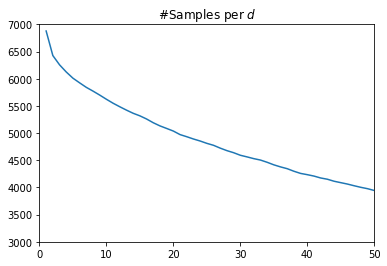

In [18]:
dist_5 = date.groupby('dist_5').Response.agg(['mean', 'sum', 'count'])
plt.plot(dist_5.index, dist_5['count'])
plt.axis([0, 50, 3000, 7000])
plt.title('#Samples per $d$')
plt.show()

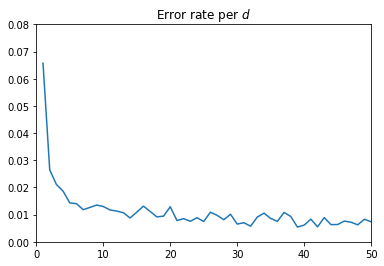

In [19]:
plt.plot(dist_5.index, dist_5['mean'])
plt.axis([0, 50, 0, 0.08])
plt.title('Error rate per $d$')
plt.show()

### Row distance to next error when sorted by start date and ID
$P(\text{error}\mid d=1)=0.065$, $d$ is the next distance.

It's the same as row distance to previous error. This means that the error distribution around an existing error is symmetric. This is actually obvious, because **a pair of errors contribute to the distribution on two sides symmetrically**.

In [20]:
date['dist_6'] = 9999999*np.ones(len(date), dtype=int)
date.loc[date.Response==1, 'dist_6'] = date.index[date.Response==1]
date['dist_6'] = date['dist_6'].shift(-1).fillna(9999999).astype(int)

date['dist_6'] = date['dist_6'].iloc[::-1].cummin().iloc[::-1] - date.index

In [21]:
date.groupby('dist_6').Response.agg(['mean', 'sum', 'count']).head()

,mean,sum,count
dist_6,,,
1,0.065726,452,6877
2,0.026459,170,6425
3,0.021103,132,6255
4,0.018618,114,6123
5,0.014312,86,6009


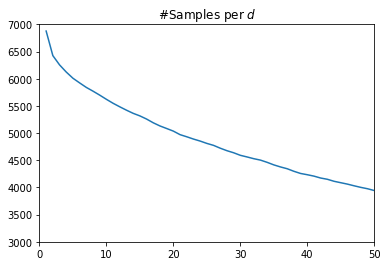

In [22]:
dist_6 = date.groupby('dist_6').Response.agg(['mean', 'sum', 'count'])
plt.plot(dist_6.index, dist_6['count'])
plt.axis([0, 50, 3000, 7000])
plt.title('#Samples per $d$')
plt.show()

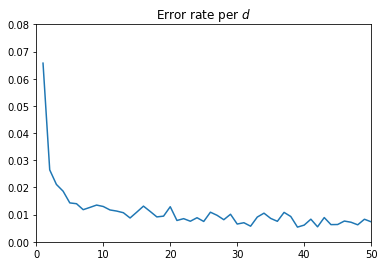

In [23]:
plt.plot(dist_6.index, dist_6['mean'])
plt.axis([0, 50, 0, 0.08])
plt.title('Error rate per $d$')
plt.show()

### Time and frequency analysis

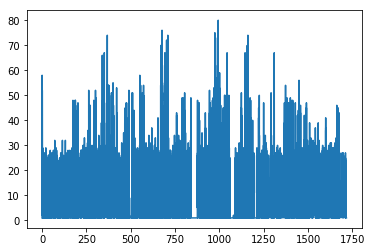

In [24]:
# Groupby time points
x = date.groupby('date_start').Response.agg(['mean', 'sum', 'count']).sort_values(['count'], ascending=False)
x.sort_index(inplace=True)

plt.plot(x.index, x['count'])

But time intervals are not uniform

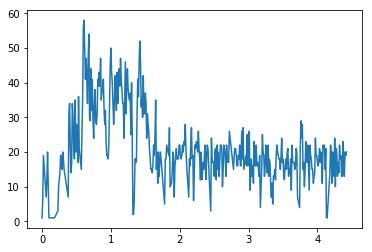

In [25]:
N = 400
plt.plot(x.index[:N], x['count'].values[:N])

So we need to first interpolate the sequence to uniform intervals

/home/li/miniconda3/envs/kaggle/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.


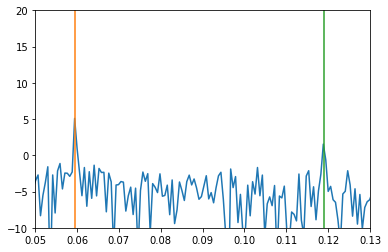

In [26]:
import scipy.fftpack

t = np.arange(x.index.min(), x.index.max(), 0.01) # time axis
x_counts = np.interp(t, x.index, x['count']) # interpolated part counts 
x_error_rate = np.interp(t, x.index, x['mean']) # interpolated part error rate
x_errors = np.interp(t, x.index, x['sum']) # interpolated part error

N = t.shape[0] # total number of time points
T = 0.01 # time interval
f = np.linspace(0.0, 1.0/(2.0*T), N/2) # frequency axis

y_counts = scipy.fftpack.fft(x_counts) # fft of x_counts
y_errors = scipy.fftpack.fft(x_errors) # fft of x_errors
y_error_rate = scipy.fftpack.fft(x_error_rate) # fft of x_error_rate
plt.plot(f, 10*np.log10(2.0/N * np.abs(y_counts[:N//2]))) # plot frequency 
plt.axis([0.05, 0.13, -10.0, 20.0]) # zoom in
plt.plot([0.0595, 0.0595], [-10, 20])
plt.plot([0.119, 0.119], [-10, 20])

We find two nontrivial peaks at round 0.06 and 0.12, indicating one repeated pattern in `x_counts`. The inverse of the frequency is $1/0.06=16.7$, which resembles the number of hours per week (168 hours). And $1/16.8=0.0595$ is exactly the frequency of the first peak.

So we conclude that the time scale is 10 hours/unit. The whole data set has 1716.53 time units, equivalent to 102.1 weeks,  or 715.2 days, or 2 years.

Let us rescale time axis.

Text(0.5,1,'A weekend')

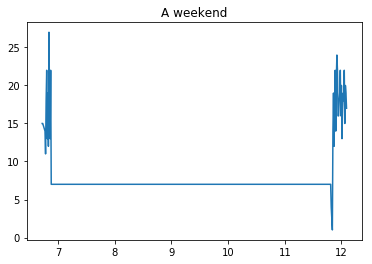

In [27]:
M = 1680 # this is one week's samples
# N1 = int(M*1 + 1.65*M/7)
# N2 = int(M*1 + 2.3*M/7)
N1 = int(M*0+0.40*M)
N2 = int(M*0+0.72*M)
plt.plot(t[N1:N2+1], x_counts[N1:N2+1])
plt.title('A weekend')

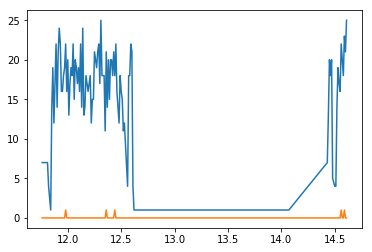

In [28]:
M = 1680
# N1 = int(M*1 + 1.65*M/7)
# N2 = int(M*1 + 2.3*M/7)
N1 = int(M*0+0.70*M)
N2 = int(M*0+0.87*M)
plt.plot(t[N1:N2+1], x_counts[N1:N2+1])
plt.plot(t[N1:N2+1], x_errors[N1:N2+1])

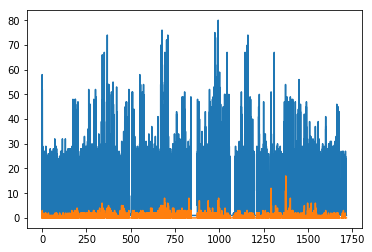

In [29]:
M = 1680
# N1 = int(M*1 + 1.65*M/7)
# N2 = int(M*1 + 2.3*M/7)
N1 = int(M*0+0.0*M)
N2 = int(M*180+0.0*M)
plt.plot(t[N1:N2+1], x_counts[N1:N2+1])
plt.plot(t[N1:N2+1], x_errors[N1:N2+1])
# plt.axis([-1, 65, 0, 30])

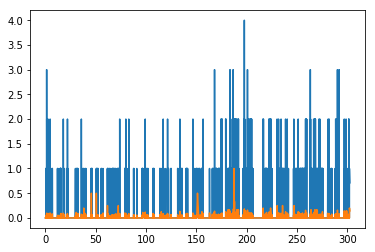

In [30]:
M = 1680
# N1 = int(M*1 + 1.65*M/7)
# N2 = int(M*1 + 2.3*M/7)
N1 = int(M*0+0.0*M)
N2 = int(M*18+0.0*M)
plt.plot(t[N1:N2+1], x_errors[N1:N2+1])
plt.plot(t[N1:N2+1], x_error_rate[N1:N2+1])
# plt.axis([-1, 65, 0, 30])

**But no pattern in error and error rate**

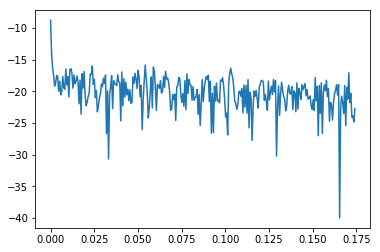

In [31]:
Ns = 300
plt.plot(f[:Ns], 10*np.log10(2.0/N * np.abs(y_errors[:Ns]))) # plot frequency 

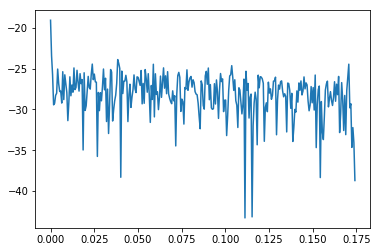

In [32]:
Ns = 300
plt.plot(f[:Ns], 10*np.log10(2.0/N * np.abs(y_error_rate[:Ns]))) # plot frequency 

### Analysis of end time
Previously we analyzed the start time of each part, let's also look at the end time.

In [33]:
z = date.groupby('date_end').Response.agg(['mean', 'sum', 'count']).sort_values(['count'], ascending=False)
z.sort_index(inplace=True)

z_counts = np.interp(t, z.index, z['count']) # interpolated part counts 
z_error_rate = np.interp(t, z.index, z['mean']) # interpolated part error rate
z_errors = np.interp(t, z.index, z['sum']) # interpolated part error

Time domain start and end time series

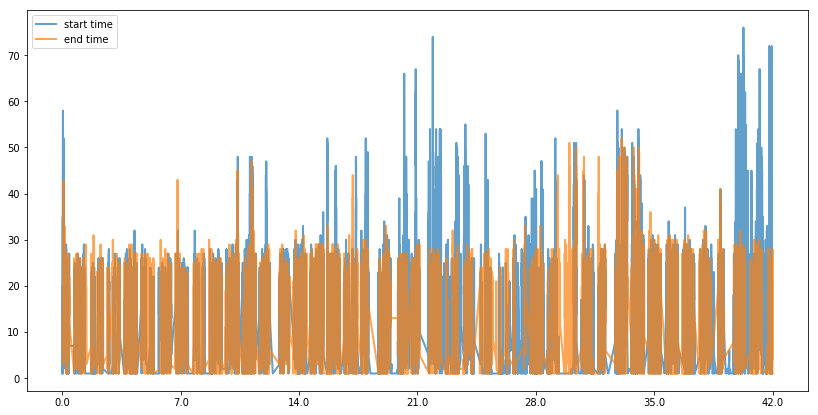

In [35]:
M = 1680 # 16.8 time units
# N1 = int(M*1 + 1.65*M/7)
# N2 = int(M*1 + 2.3*M/7)
N1 = int(M*0+0.0*M)
N2 = int(M*42+0.0*M)

plt.figure(figsize=(14,7))
line1 = plt.plot(t[N1:N2+1], x_counts[N1:N2+1], label='start time')
line2 = plt.plot(t[N1:N2+1], z_counts[N1:N2+1], label='end time')
plt.setp(line1, alpha=0.7, linewidth=2)
plt.setp(line2, alpha=0.7, linewidth=2)
# plt.xticks(locs=np.arange(0, N2, N2/42), labels=np.arange(0, 42, 1))
locs = np.arange(0, 16.8*49, 16.8*7)
plt.xticks(locs, ['{:.1f}'.format(n*10/168) for n in locs])
plt.legend()

In [36]:
zf_counts = scipy.fftpack.fft(z_counts) # fft of x_counts
zf_errors = scipy.fftpack.fft(z_errors) # fft of x_errors
zf_error_rate = scipy.fftpack.fft(z_error_rate) # fft of x_error_rate

**End time has more patterns**

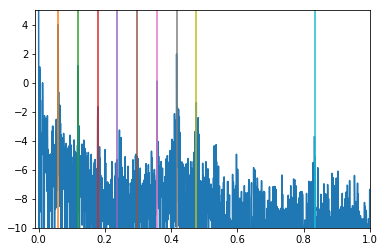

In [37]:
Ns = 3000
plt.plot(f[:Ns], 10*np.log10(2.0/N * np.abs(zf_counts[:Ns]))) # plot frequency 
plt.axis([-0.01, 1., -10, 5])
plt.plot([0.0595, 0.0595], [-10, 20])
plt.plot([0.119, 0.119], [-10, 20])
plt.plot([0.0595*3, 0.0595*3], [-10, 20])
plt.plot([0.0595*4, 0.0595*4], [-10, 20])
plt.plot([0.0595*5, 0.0595*5], [-10, 20])
plt.plot([0.0595*6, 0.0595*6], [-10, 20])
plt.plot([0.0595*7, 0.0595*7], [-10, 20]) # 7 weeks frequency is very strong
plt.plot([0.0595*8, 0.0595*8], [-10, 20])
plt.plot([0.0595*14, 0.0595*14], [-10, 20]) # 14 weeks frequency 

### Difference between neighboring time points

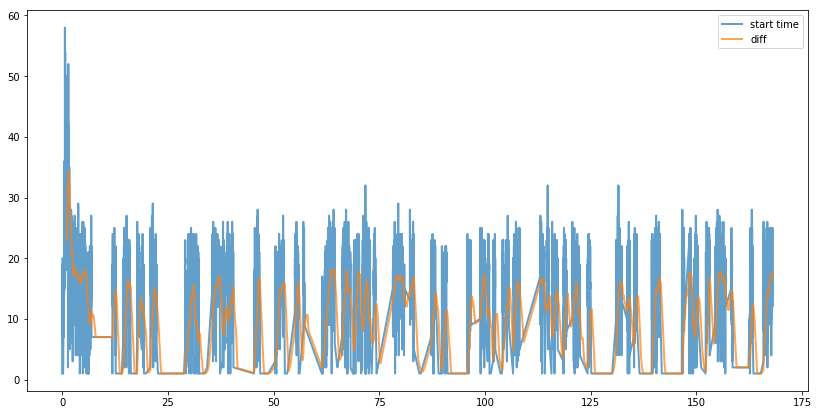

In [38]:
ser = pd.Series(x_counts, index=t)
x_counts_mean = ser.rolling(window=100, win_type='boxcar').mean().values

M = 1680 # 16.8 time units
N1 = int(M*0+0.0*M)
N2 = int(M*10+0.0*M)

plt.figure(figsize=(14,7))
line1 = plt.plot(t[N1:N2+1], x_counts[N1:N2+1], label='start time')
line2 = plt.plot(t[N1:N2+1], x_counts_mean[N1:N2+1], label='diff')
plt.setp(line1, alpha=0.7, linewidth=2)
plt.setp(line2, alpha=0.7, linewidth=2)
# locs = np.arange(0, 16.8*1, 16.8*7)
# plt.xticks(locs, ['{:.1f}'.format(n*10/168) for n in locs])
plt.legend()

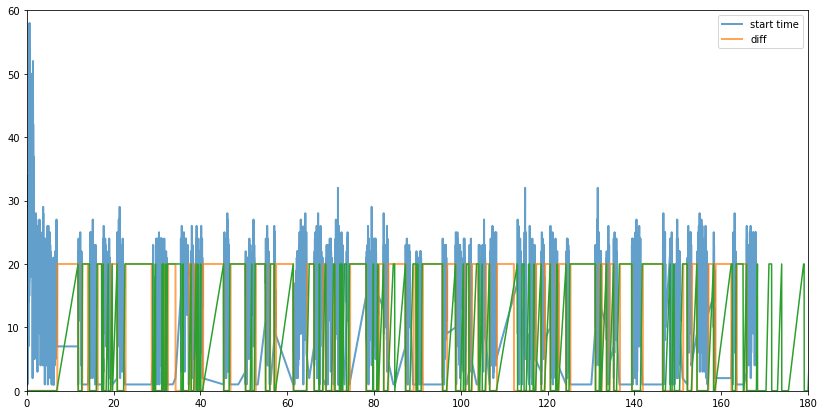

In [39]:
ser = pd.Series(x_counts, index=t)
x_counts_diff = ser.diff().abs().fillna(1)
# x_counts_diff = x_counts_diff[x_counts_diff<0.01].values
th = 0.1
a = x_counts_diff<th
b = (x_counts_diff>=th) | (x_counts>15)
x_counts_diff[a] = 20
x_counts_diff[b] = 0
x_counts_diff = x_counts_diff.rolling(window=15, win_type='boxcar').mean()
x_counts_diff[x_counts_diff<19] = 0
x_counts_diff = x_counts_diff.values

u = x.reset_index()
u['diff'] = u.date_start.diff().fillna(0.01)
u1 = u['diff']<0.1
u2 = u['diff']>=0.1
u.loc[u1, 'diff'] = 0
u.loc[u2, 'diff'] = 20

M = 1680 # 16.8 time units
N1 = int(M*0+0.0*M)
N2 = int(M*10+0.0*M)

plt.figure(figsize=(14,7))
line1 = plt.plot(t[N1:N2+1], x_counts[N1:N2+1], label='start time')
line2 = plt.plot(t[N1:N2+1], x_counts_diff[N1:N2+1], label='diff')
line3 = plt.plot(u['date_start'].values, u['diff'].values)
plt.setp(line1, alpha=0.7, linewidth=2)
plt.setp(line2, alpha=0.7, linewidth=2)
# locs = np.arange(0, 16.8*1, 16.8*7)
# plt.xticks(locs, ['{:.1f}'.format(n*10/168) for n in locs])
plt.axis([0, 180, 0, 60])
plt.legend()

### Histogram of the position inside a certain period

The period can be one day, one week, multiple days, multiple weeks. For example, it helps us create new features, like Monday, weekends, the last hour of a week, the $x$-th hour of a $y$-week period, etc.

#### Histogram based on days in a week
By plotting the histograms counts, errors, and error rates of start and finish time during the week, we can identify weekends and workdays, and distribution of errors in a week.

- Parts never finish during a certain period in a week, this should be weekends.
- At the last hour of Fridays, weekends, the first hour of Mondays, and some other times have high error rates.
- Clear patterns in finish time, indicating days during a week.

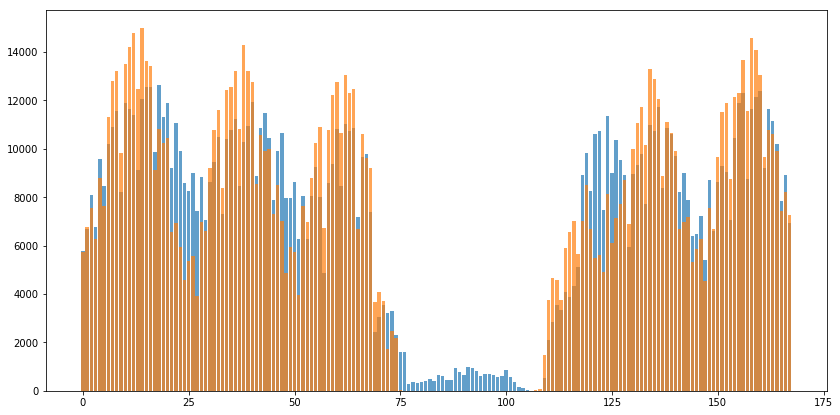

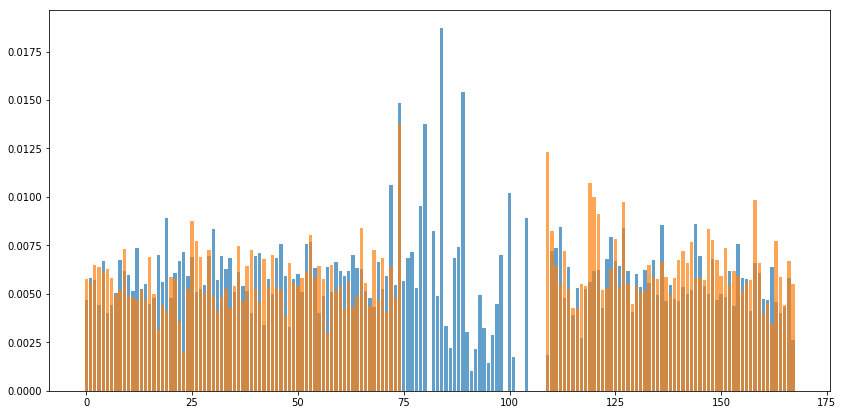

In [43]:
Nm = 1
tmp = (date['date_start'] % (16.8 * Nm))/(16.8*Nm)*168
date['date_start_mod1'] = tmp.values.astype(int)
a = date.groupby('date_start_mod1').Response.agg(['mean', 'sum', 'count'])
a.reset_index(inplace=True)
a.sort_values('date_start_mod1', ascending=True)

tmp = (date['date_end'] % (16.8 * Nm))/(16.8*Nm)*168
date['date_end_mod1'] = tmp.values.astype(int)
b = date.groupby('date_end_mod1').Response.agg(['mean', 'sum', 'count'])
b.reset_index(inplace=True)
b.sort_values('date_end_mod1', ascending=True)

# plt.plot(a['count']/10000)
# plt.plot(a['sum']/100)
fig = plt.figure(figsize=(14, 7))
plt.bar(a['date_start_mod1'], a['count'], alpha=0.7)
plt.bar(b['date_end_mod1'], b['count'], alpha=0.7)
# plt.plot(b['count']*10**-6)
plt.show()

fig = plt.figure(figsize=(14, 7))
plt.bar(a['date_start_mod1'], a['mean'], alpha=0.7)
plt.bar(b['date_end_mod1'], b['mean'], alpha=0.7)
# plt.plot(b['count']*10**-6)
plt.show()

#### Histogram based on hours in a day
Error rate seems uniformly distributed in all hours.

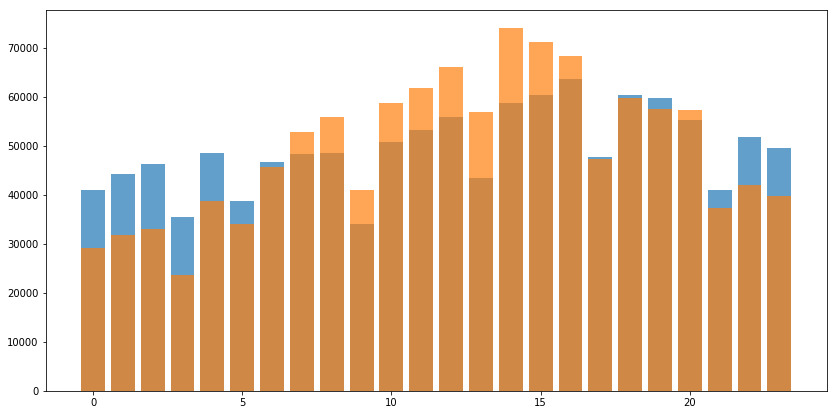

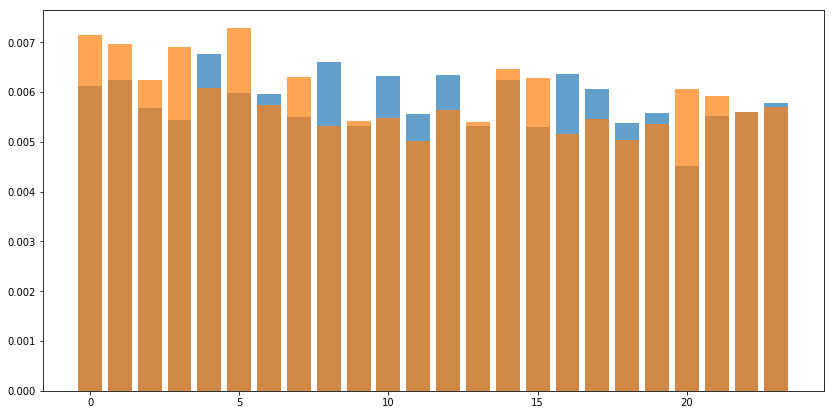

In [55]:
Nm = 1
P = 24
tmp = (date['date_start'] % (P * Nm / 10))/(P * Nm / 10) * P
date['date_start_mod1'] = tmp.values.astype(int)
a = date.groupby('date_start_mod1').Response.agg(['mean', 'sum', 'count'])
a.reset_index(inplace=True)
a.sort_values('date_start_mod1', ascending=True)

tmp = (date['date_end'] % (P * Nm / 10))/(P * Nm / 10) * P
date['date_end_mod1'] = tmp.values.astype(int)
b = date.groupby('date_end_mod1').Response.agg(['mean', 'sum', 'count'])
b.reset_index(inplace=True)
b.sort_values('date_end_mod1', ascending=True)

# plt.plot(a['count']/10000)
# plt.plot(a['sum']/100)
fig = plt.figure(figsize=(14, 7))
plt.bar(a['date_start_mod1'], a['count'], alpha=0.7)
plt.bar(b['date_end_mod1'], b['count'], alpha=0.7)
# plt.plot(b['count']*10**-6)
plt.show()

fig = plt.figure(figsize=(14, 7))
plt.bar(a['date_start_mod1'], a['mean'], alpha=0.7)
plt.bar(b['date_end_mod1'], b['mean'], alpha=0.7)
# plt.plot(b['count']*10**-6)
plt.show()


#### Histogram based on hours in multiple weeks

- ~~A peak in the 3 week period error rate of end time~~

- ~~A peak in the 5, 6 week period error rate of start time.~~

- Start time have clear peaks around weekends

- For too big period (e.g., 6, 8, 10, 11, 12 weeks), results are not reliable.

- It is possible that in some certain week period, there are too few samples, so error rate is high but confidence interval is also large. So the period cannot be too long.

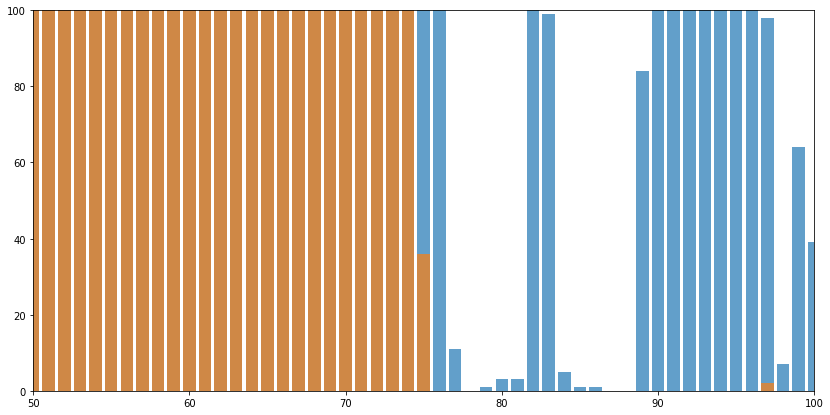

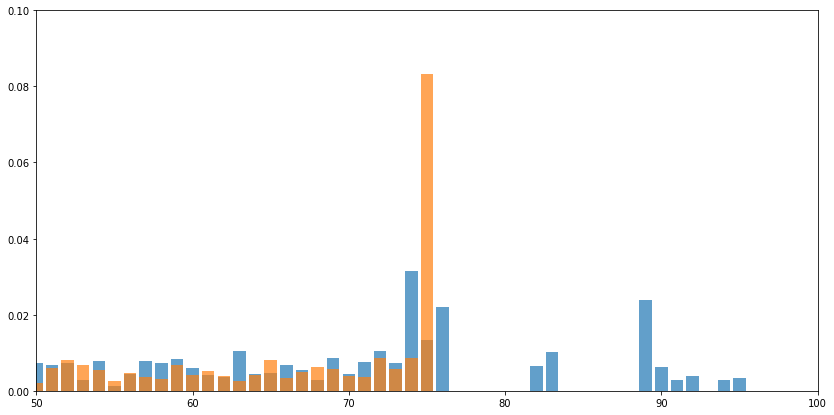

In [86]:
# zoom in
Nm = 1
P = 24 * 7 * 3
tmp = (date['date_start'] % (P * Nm / 10))/(P * Nm / 10) * P
date['date_start_mod1'] = tmp.values.astype(int)
a = date.groupby('date_start_mod1').Response.agg(['mean', 'sum', 'count'])
a.reset_index(inplace=True)
a.sort_values('date_start_mod1', ascending=True)

tmp = (date['date_end'] % (P * Nm / 10))/(P * Nm / 10) * P
date['date_end_mod1'] = tmp.values.astype(int)
b = date.groupby('date_end_mod1').Response.agg(['mean', 'sum', 'count'])
b.reset_index(inplace=True)
b.sort_values('date_end_mod1', ascending=True)

fig = plt.figure(figsize=(14, 7))
plt.bar(a['date_start_mod1'], a['count'], alpha=0.7)
plt.bar(b['date_end_mod1'], b['count'], alpha=0.7)
plt.axis([50, 100, 0, 100.])
plt.show()

fig = plt.figure(figsize=(14, 7))
#plt.bar(a['date_start_mod1'], a['sum']/60, alpha=0.7)
plt.bar(a['date_start_mod1'], a['mean'], alpha=0.7)
plt.bar(b['date_end_mod1'], b['mean'], alpha=0.7)
plt.axis([50, 100, 0, .1])
plt.show()

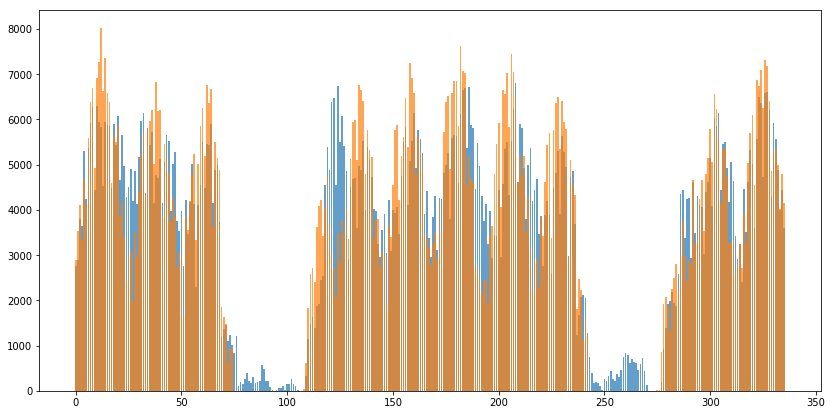

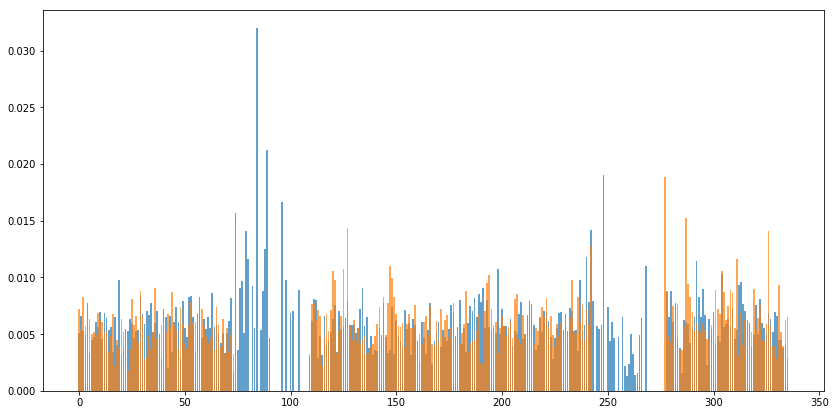

In [89]:
Nm = 1
P = 24 * 7 * 2
tmp = (date['date_start'] % (P * Nm / 10))/(P * Nm / 10) * P
date['date_start_mod1'] = tmp.values.astype(int)
a = date.groupby('date_start_mod1').Response.agg(['mean', 'sum', 'count'])
a.reset_index(inplace=True)
a.sort_values('date_start_mod1', ascending=True)

tmp = (date['date_end'] % (P * Nm / 10))/(P * Nm / 10) * P
date['date_end_mod1'] = tmp.values.astype(int)
b = date.groupby('date_end_mod1').Response.agg(['mean', 'sum', 'count'])
b.reset_index(inplace=True)
b.sort_values('date_end_mod1', ascending=True)

# plt.plot(a['count']/10000)
# plt.plot(a['sum']/100)
fig = plt.figure(figsize=(14, 7))
plt.bar(a['date_start_mod1'], a['count'], alpha=0.7)
plt.bar(b['date_end_mod1'], b['count'], alpha=0.7)
# plt.plot(b['count']*10**-6)
plt.show()

fig = plt.figure(figsize=(14, 7))
plt.bar(a['date_start_mod1'], a['mean'], alpha=0.7)
plt.bar(b['date_end_mod1'], b['mean'], alpha=0.7)
# plt.plot(b['count']*10**-6)
plt.show()

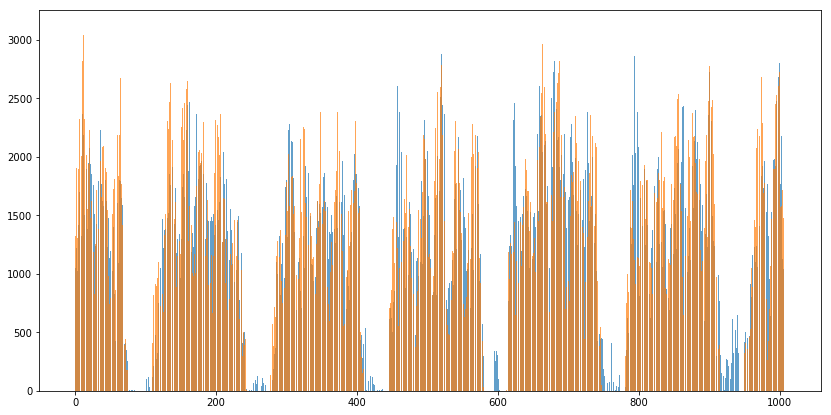

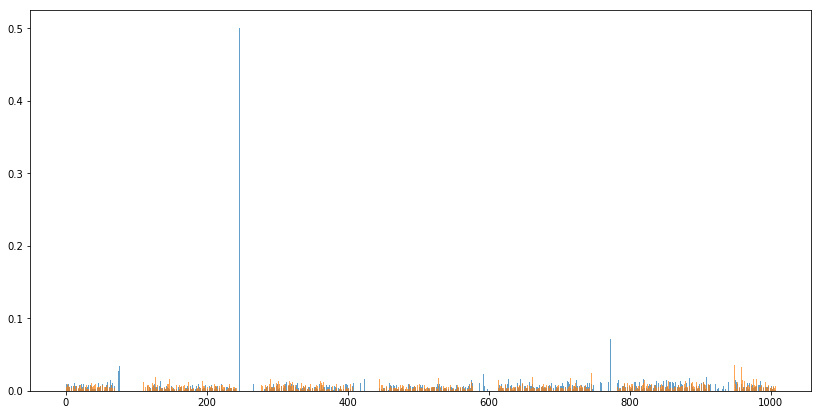

In [61]:
Nm = 1
P = 24 * 7 * 6
tmp = (date['date_start'] % (P * Nm / 10))/(P * Nm / 10) * P
date['date_start_mod1'] = tmp.values.astype(int)
a = date.groupby('date_start_mod1').Response.agg(['mean', 'sum', 'count'])
a.reset_index(inplace=True)
a.sort_values('date_start_mod1', ascending=True)

tmp = (date['date_end'] % (P * Nm / 10))/(P * Nm / 10) * P
date['date_end_mod1'] = tmp.values.astype(int)
b = date.groupby('date_end_mod1').Response.agg(['mean', 'sum', 'count'])
b.reset_index(inplace=True)
b.sort_values('date_end_mod1', ascending=True)

# plt.plot(a['count']/10000)
# plt.plot(a['sum']/100)
fig = plt.figure(figsize=(14, 7))
plt.bar(a['date_start_mod1'], a['count'], alpha=0.7)
plt.bar(b['date_end_mod1'], b['count'], alpha=0.7)
# plt.plot(b['count']*10**-6)
plt.show()

fig = plt.figure(figsize=(14, 7))
plt.bar(a['date_start_mod1'], a['mean'], alpha=0.7)
plt.bar(b['date_end_mod1'], b['mean'], alpha=0.7)
# plt.plot(b['count']*10**-6)
plt.show()

### Distribution of production duration 
Do not reveal too much.

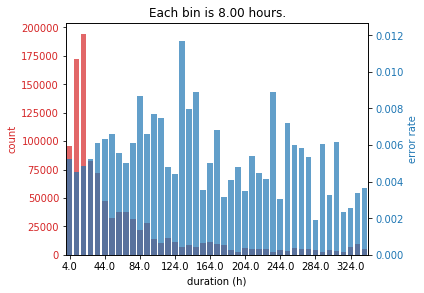

In [180]:
Nbins = 874 # 8 hours per bin
#Nbins = 6992 # 1 hour per bin
#Nbins = 291 # 12 hours per bin
#Nbins = 146 # 24 hours per bin
xlim = 168 * 2 # in hours
dmin = date['date_duration'].min() # dmin=0
dmax = date['date_duration'].max() # dmax=699.2
tbin = (dmax - dmin) * 10 / Nbins # hours per bin
Nxlim = int(xlim / tbin) # number of bins to show
tmp = (date['date_duration'] - dmin) / (dmax - dmin) * Nbins
date['date_duration_bin1'] = tmp.values.astype(int)
c = date.groupby('date_duration_bin1').Response.agg(['mean', 'sum', 'count'])
c.reset_index(inplace=True)
c.sort_values('date_duration_bin1', ascending=True)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('duration (h)')
ax1.set_ylabel('count', color=color)
ax1.set_xlim([-0.5, Nxlim+0.5])
xticks = ['{:.1f}'.format(tmp) for tmp in ax1.get_xticks() * tbin + 0.5 * tbin]
ax1.set_xticklabels(xticks)
ax1.bar(c['date_duration_bin1'], c['count'], alpha=0.7, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('error rate', color=color)  # we already handled the x-label with ax1
ax2.bar(c['date_duration_bin1'], c['mean'], alpha=0.7, color=color)
ax2.set_ylim([0, c['mean'].iloc[:Nxlim].max()+0.001])
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Each bin is {:.2f} hours.'.format(tbin))
plt.show()

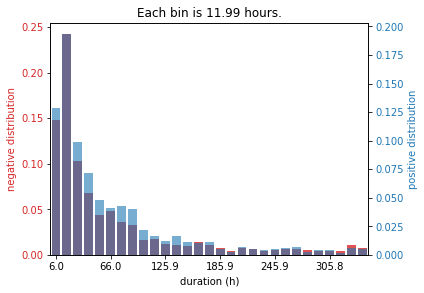

In [201]:
Nbins = 874 # 8 hours per bin
Nbins = 6992 # 1 hour per bin
Nbins = 583 # 12 hour per bin
#Nbins = 291 # 24 hours per bin
#Nbins = 146 # 48 hours per bin
xlim = 168 * 2 # in hours
dmin = date['date_duration'].min() # dmin=0
dmax = date['date_duration'].max() # dmax=699.2
tbin = (dmax - dmin) * 10 / Nbins # hours per bin
Nxlim = int(xlim / tbin) # number of bins to show
tmp = (date['date_duration'] - dmin) / (dmax - dmin) * Nbins
date['date_duration_bin1'] = tmp.values.astype(int)
c = date.groupby(['Response', 'date_duration_bin1']).count()
c.reset_index(level=1, inplace=True)

c.sort_values('date_duration_bin1', ascending=True)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('duration (h)')
ax1.set_ylabel('negative distribution', color=color)
ax1.set_xlim([-0.5, Nxlim+0.5])
xticks = ['{:.1f}'.format(tmp) for tmp in ax1.get_xticks() * tbin + 0.5 * tbin]
ax1.set_xticklabels(xticks)
ax1.bar(c.loc[0, 'date_duration_bin1'], 
        c.loc[0, 'date_duration']/c.loc[0, 'date_duration'].sum(), 
        alpha=0.8, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('positive distribution', color=color)  # we already handled the x-label with ax1
ax2.bar(c.loc[1, 'date_duration_bin1'], 
        c.loc[1, 'date_duration']/c.loc[1, 'date_duration'].sum(), 
        alpha=0.6, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Each bin is {:.2f} hours.'.format(tbin))
plt.show()

In [202]:
c['date_duration'].describe()

count       325.000000
mean       3640.507692
std       20843.728996
min           1.000000
25%           3.000000
50%          17.000000
75%         142.000000
max      285157.000000
Name: date_duration, dtype: float64

In [207]:
date.date_duration.describe()

count    1.183165e+06
mean     1.071842e+01
std      1.701537e+01
min      0.000000e+00
25%      1.710000e+00
50%      3.700000e+00
75%      1.177000e+01
max      6.992000e+02
Name: date_duration, dtype: float64

In [218]:
date

,Id,date_start,date_end,date_duration,Response,dist_1,dist_3,dist_2,dist_4,cnt,dist_5,dist_6,date_start_mod1,date_end_mod1,date_duration_bin1,dist_7,dist_8
266,251456,0.40,0.46,0.06,0,79,894,23341,-36778,1.0,266,19,4,4,0,9999999,-13348
234,264804,0.39,0.46,0.07,0,155,456,3341,-14506,1.0,234,51,3,4,0,13348,-57114
272,321918,0.40,0.46,0.06,0,156,218,16328,-202,1.0,272,13,4,4,0,57114,-73141
277,395059,0.40,0.46,0.06,0,14,60,29324,-2588,1.0,277,8,4,4,0,73141,-2588
278,397647,0.40,0.46,0.06,0,457,115,2588,-30561,1.0,278,7,4,4,0,2588,-9737
244,407384,0.39,0.46,0.07,0,18,111,3148,-68424,1.0,244,41,3,4,0,9737,-71953
282,479337,0.40,0.46,0.06,0,50,485,20249,-43466,1.0,282,3,4,4,0,71953,-69310
284,548647,0.40,0.46,0.06,0,67,32,25844,-11191,1.0,284,1,4,4,0,69310,-17337
287,565984,0.40,0.46,0.06,0,39,305,6145,-74191,1.0,2,120,4,4,0,17337,-68107
257,634091,0.39,0.46,0.07,0,282,367,2274,-7211,1.0,257,28,3,4,0,68107,-7211
